# Example counterfactual explanation generation workflow

## train GNN

In [3]:
import torch
from torch.optim import AdamW
from models import get_model
from utils import get_loader, train, test, evaluation
loader_name = 'Neighbor'
hidden_size = 128
model_name = 'RGCN'
learning_rate = 0.002
epoch_num = 200
data_path = 'data/processed/data_homo.pt'
model_save_path = "models/"
# Set up the device for training
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
num_relations = 5
## DATA LOADING AND SAMPLING
data = torch.load(data_path)
edge_type = data.edge_attr[:, 1:].argmax(dim=1)
# print(f"HeteroData object: {data}")
train_loader, val_loader, test_loader = get_loader(data, loader_name)  # Initialise Dataloaders

## MODELLING
num_features = data.x.shape[1]
num_classes = data.y.shape[1]
model = get_model(model_name, num_features, hidden_size, num_classes, device)
optimizer = AdamW(model.parameters(), lr=learning_rate)


In [4]:
## TRAINING
for epoch in range(1, epoch_num + 1):
    loss = train(model_name, model, train_loader, optimizer, device)
    val_acc = test(model_name, model, val_loader, device)
    test_acc = test(model_name, model, test_loader, device)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, ',
          f'Val: {val_acc:.4f} Test: {test_acc:.4f}')

## EVALUATION & SAVING
results = evaluation(model_name, model, test_loader, device)
print(results)

Epoch: 01, Loss: 0.1154,  Val: 0.0425 Test: 0.0450
Epoch: 02, Loss: 0.0384,  Val: 0.0312 Test: 0.0318
Epoch: 03, Loss: 0.0303,  Val: 0.0270 Test: 0.0271
Epoch: 04, Loss: 0.0267,  Val: 0.0242 Test: 0.0245
Epoch: 05, Loss: 0.0242,  Val: 0.0223 Test: 0.0225
Epoch: 06, Loss: 0.0224,  Val: 0.0206 Test: 0.0210
Epoch: 07, Loss: 0.0209,  Val: 0.0197 Test: 0.0200
Epoch: 08, Loss: 0.0195,  Val: 0.0189 Test: 0.0190
Epoch: 09, Loss: 0.0183,  Val: 0.0177 Test: 0.0174
Epoch: 10, Loss: 0.0173,  Val: 0.0166 Test: 0.0168
Epoch: 11, Loss: 0.0166,  Val: 0.0160 Test: 0.0160
Epoch: 12, Loss: 0.0158,  Val: 0.0154 Test: 0.0153
Epoch: 13, Loss: 0.0151,  Val: 0.0148 Test: 0.0148
Epoch: 14, Loss: 0.0147,  Val: 0.0146 Test: 0.0144
Epoch: 15, Loss: 0.0140,  Val: 0.0141 Test: 0.0141
Epoch: 16, Loss: 0.0138,  Val: 0.0139 Test: 0.0140
Epoch: 17, Loss: 0.0134,  Val: 0.0135 Test: 0.0137
Epoch: 18, Loss: 0.0128,  Val: 0.0132 Test: 0.0129
Epoch: 19, Loss: 0.0127,  Val: 0.0130 Test: 0.0129
Epoch: 20, Loss: 0.0123,  Val: 

## Comput Counterfactuals

In [5]:
from torch_geometric.utils import k_hop_subgraph
from torch.nn.functional import cosine_similarity

# construct neighbouring graph
def get_1hop_complete_subgraph(data, node_idx):
    """
    from the input graph, specify a node index, get 1-hop neighbourhood of the node,
    both from source to target (input node as target)
    and from target to source (input node as source)
    :param data: torch geometric data, full dataset
    :param node_idx: int, node index
    :return: tensor list of neighbouring node indices including node index, tensor list of edges
    """
    stt_subgraph_info = k_hop_subgraph(node_idx=node_idx, num_hops=1, edge_index=data.edge_index,
                                       relabel_nodes=False, flow="source_to_target")
    tts_subgraph_info = k_hop_subgraph(node_idx=node_idx, num_hops=1, edge_index=data.edge_index,
                                       relabel_nodes=False, flow="target_to_source")
    stt_nodes = stt_subgraph_info[0]
    tts_nodes = tts_subgraph_info[0]
    subg_nodes = torch.unique(torch.cat((stt_nodes, tts_nodes)))
    stt_edges = stt_subgraph_info[1].t()
    tts_edges = tts_subgraph_info[1].t()
    subg_edges = torch.unique(torch.cat((stt_edges, tts_edges), dim=0), dim=0)
    return subg_nodes, subg_edges

In [6]:
def graph_dissimilarity(data, edge_idx_store, node_idx_1, subg_nodes_1, subg_edges_1, subg_nodes_2, subg_edges_2,
                        lamb_n=1, lamb_e=1, lamb_g=1):
    return lamb_n * node_features_dissimilarity(data, node_idx_1, subg_nodes_2) + lamb_e * edge_features_dissimilarity(
        data, edge_idx_store, subg_edges_1, subg_edges_2) + lamb_g * graph_structure_dissimilarity(subg_edges_1,
                                                                                                   subg_edges_2)


# node features dissimilarity ranged [0, 1]:
# normalised L2 distance + cosine distance, between the input node 1 and the neighbouring nodes of node 2
def node_features_dissimilarity(data, node_idx_1, sug_nodes_2):
    feat1 = data.x[node_idx_1].view(1, -1)
    feat2 = data.x[sug_nodes_2]
    return (torch.norm(feat2 - feat1, p=2, dim=1).mean() / (
            (torch.norm(feat2, p=2, dim=1).mean()) + torch.norm(feat1, p=2)) + (
                    1 - (cosine_similarity(feat1, feat2).mean() + 1) / 2)) / 2


# edge features dissimilarity ranged [0, 1]:
def edge_features_dissimilarity(data, edge_idx_store, subg_edges_1, subg_edges_2):
    idxs1 = get_edge_idx(edge_idx_store, subg_edges_1)
    idxs2 = get_edge_idx(edge_idx_store, subg_edges_2)
    edge_attrs = data.edge_attr[:, 1:].argmax(dim=1).to(torch.float32)
    edge_attrs1 = edge_attrs[idxs1]
    edge_attrs2 = edge_attrs[idxs2]
    return (edge_attrs1.mean() - edge_attrs2.mean()).abs() / 4


def get_edge_idx(edge_idx_store, subg_edges):
    idxs = []
    for item in subg_edges:
        idxs.append(edge_idx_store[f"{item[0]},{item[1]}"])
    return torch.Tensor(idxs).to(torch.int64)


# graph structure dissimilarity
def graph_structure_dissimilarity(subg_edges_1, subg_edges_2):
    return abs(len(subg_edges_1) - len(subg_edges_2)) / max(len(subg_edges_1), len(subg_edges_2))

In [7]:
def compute_counterfactual(node_idx, target_prediction, predictions, data, edge_idx_store):
    """
    compute one counterfactual for node indicated by node_idx
    :param node_idx: int
    :param predictions: predictions, either regression or classification
    :param target_prediction
    :param data
    :return: counterfactual node, counterfactual subgraph, input subgraph, graph dissimilarity with input graph
    """
    candidate_ces_idxs = torch.where(predictions==target_prediction)[0]
    explainee_sgraph = get_1hop_complete_subgraph(data, node_idx)
    optimal_ce_node = None
    optimal_ce_sgraph = None
    optimal_ce_dissimilarity = 100
    for idx in candidate_ces_idxs:
        candidate_ce_sgraph = get_1hop_complete_subgraph(data, int(idx))
        this_ce_dissimilarity = graph_dissimilarity(data, edge_idx_store, node_idx, explainee_sgraph[0], explainee_sgraph[1], candidate_ce_sgraph[0], candidate_ce_sgraph[1])
        if this_ce_dissimilarity <= optimal_ce_dissimilarity:
            optimal_ce_dissimilarity = this_ce_dissimilarity
            optimal_ce_node = idx
            optimal_ce_sgraph = candidate_ce_sgraph
    return optimal_ce_node, optimal_ce_sgraph, explainee_sgraph, optimal_ce_dissimilarity

## Example usage

In [21]:
# get all predictions and transform to classification labels
y_pred = model(data.x, data.edge_index, data.edge_attr[:, 1:].argmax(dim=1))
y_pred_class = torch.argmax(y_pred, dim=1)

# construct a dict to store index for edge index
edge_idx_store = {}
for i, item in enumerate(data.edge_index.t()):
    edge_idx_store[f"{item[0]},{item[1]}"] = i

In [28]:
print(torch.where(y_pred_class==0))

(tensor([  40,   46,   51,   67,   86,   88,   89,   91,   96,  103,  118,  123,
         129,  174,  321, 1090, 1346, 2220, 2249, 2250, 2257, 2268, 2273, 2755,
        2898, 3163, 3167, 3332, 3333, 3534, 3535, 3671, 3672, 3726, 3918, 4032,
        4033, 4051, 4058, 4105, 4146, 4159, 4165, 4188, 4192]),)


In [52]:
# want to explain the prediction result for node
node_idx = 2220
print("original prediction: class", int(y_pred_class[node_idx]))

original prediction: class 0


In [53]:
# want to find counterfactual explanation for class 5
target_prediction = 5
optimal_ce_node, optimal_ce_sgraph, explainee_sgraph, optimal_ce_dissimilarity = compute_counterfactual(node_idx=node_idx, target_prediction=target_prediction, predictions=y_pred_class, data=data, edge_idx_store=edge_idx_store)

In [54]:
# print out counterfactual node information
print(optimal_ce_node, y_pred_class[optimal_ce_node], optimal_ce_dissimilarity)

tensor(2312) tensor(5) tensor(0.1703)


In [55]:
# print out counterfactual graph information: classification results, to examine whether they are all in the same class
print(y_pred_class[optimal_ce_sgraph[0]])

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])


In [56]:
print(optimal_ce_sgraph[0].shape)

torch.Size([11])


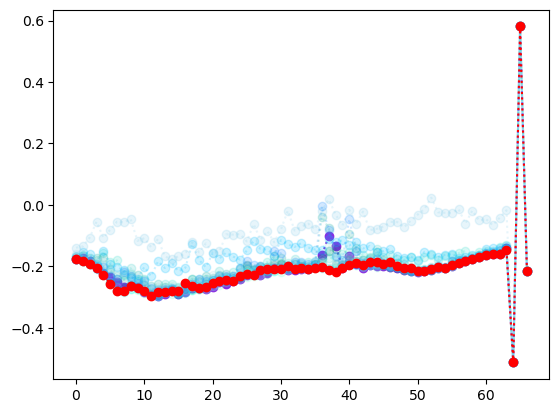

In [58]:
# plot the node features of explainee node and the nodes in the counterfactual graph:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
horizontal = range(len(data.x[node_idx]))
ax.plot(horizontal, data.x[optimal_ce_node], 'o:', color="blueviolet")
colors = ["aquamarine", "turquoise", "lightseagreen", "mediumturquoise", "paleturquoise", "teal", "aqua", "powderblue", "deepskyblue", "skyblue", "dodgerblue", "royalblue", "lavender", "slateblue", "lightsteelblue", "blue", "darkblue", "cornflowerblue", "lightskyblue", "cadetblue"]
for i, item in enumerate(optimal_ce_sgraph[0]):
    if int(item) == int(optimal_ce_node):
        continue
    ax.plot(horizontal, data.x[item], 'o:', color=colors[i], alpha=0.2)
ax.plot(horizontal, data.x[node_idx], 'or:')